# Bundled electron insert factors modelling example

## Quickly demo this notebook online
Go to http://simonbiggs.net/electrondemo to use an online version of this notebook. This can be quickly trialed with your data to determine whether or not it is worth your while.

Do note that this demo is using a free server available from http://mybinder.org. As such expect it to run relatively slow.

## Description
The code here provided is for the modelling of the portion of the electron output factor that is dependent on the shape of the shielding insert mounted within the applicator. This allows modelling insert factors using only the measured factors already available at a centre. Should all outliers be removed from the data set the user might expect as low as 0.5% standard uncertainty for factor prediction with as little as 8 data points.

The paper outlining this method is the following:
 
 > Biggs, S., Sobolewski, M., Murry, R., & Kenny, J. (2015). Spline modelling electron insert factors using routine measurements. *Physica Medica: European Journal of Medical Physics*, Volume 32, Issue 1, 255 - 259. [doi:10.1016/j.ejmp.2015.11.002](http://dx.doi.org/10.1016/j.ejmp.2015.11.002). 

If you have any issues please don't hesitate to contact me at [mail@simonbiggs.net](mailto:mail@simonbiggs.net). I am more than happy to help or to receive any feedback. 

## Disclaimer

Any use of the code accepts the [AGPL3+ license](../edit/LICENSE) which includes no warranty that this code is fit for a particular purpose. Attempts have been made to make the code transparent and it is recommended that an experienced python programmer and physicist who understands the procedure outlined in the paper and the requirements of your centre identifies whether or not this method and code is fit for your use.


## Running this notebook on your local machine
 * Download and install the relevant Anaconda Python 3.5 install from [continuum.io/downloads](https://www.continuum.io/downloads).
 * Download the zip file containing this notebook and all relevant files from http://simonbiggs.net/electronbundle.
 * Extract the zip file.
 * Run `install_required_modules.bat` to install the modules required to run this notebook.
 * Open the shortcut `open_notebook.lnk` to boot the jupyter notebook server.
 * Open the `electroninserts_notebook.ipynb` file by either clicking on the file within the jupyter dashboard or going to http://localhost:8888/notebooks/electroninserts_notebook.ipynb (this link will only work once the server is running).

## Using this notebook file

Each cell can be run by selecting it and pressing `Shift + Enter`. Step through each cell running each intern and observing the output to ensure the program is responding as expected.

## Importing all the packages to be used in this notebook

The following cell imports all the modules and functions required. Of note are `lines 13 - 15` which import the custom `electroninserts` functions. These custom functions are located within [electroninserts.py](../edit/electroninserts.py) which can be perused to ensure it is running as you would expect.

In [1]:
import dicom

from glob import glob

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook, output_file

from electroninserts import (
    parameterise_single_insert, display_parameterisation,
    create_report_from_pandas)

print("All modules successfully imported.")

All modules successfully imported.


## Parameterising shapes

Three options to parameterise shapes are given below; from raw coordinates, from an RT-DICOM file, or from a Monaco 5.10 `tel.1` file.

### From coordinates

Width = 6.53 cm
Length = 10.99 cm


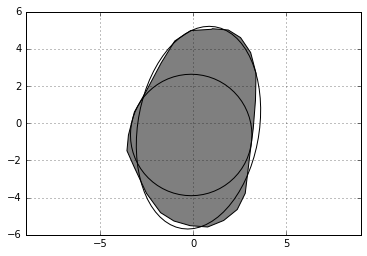

In [2]:
x = [0.99, -0.14, -1.0, -1.73, -2.56, -3.17, -3.49, -3.57, -3.17, -2.52, -1.76,
    -1.04, -0.17, 0.77, 1.63, 2.36, 2.79, 2.91, 3.04, 3.22, 3.34, 3.37, 3.08, 2.54,
    1.88, 1.02, 0.99]
y = [5.05, 4.98, 4.42, 3.24, 1.68, 0.6, -0.64, -1.48, -2.38, -3.77, -4.81,
    -5.26, -5.51, -5.58, -5.23, -4.64, -3.77, -2.77, -1.68, -0.29, 1.23, 2.68, 3.8,
    4.6, 5.01, 5.08, 5.05]

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm\nLength = {1:0.2f} cm".format(width, length))

display_parameterisation(x, y, width, length, poi)

### From RT-DICOM

If you are using the online version of this notebook you will likely want to deidentify your dicom files. http://www.dicompyler.com/ can be used to do this however I am not in a position to guarantee it will do this adequately. You need to check this yourself.

To upload the dicom file go to [notebook home](../tree) and click the "upload button" located at the top right of the dashboard.

Applicator = 10X10 (identifier name)
Energy = 12.0 (nominal)
SSD = 1001.0 (dicom units)

Width = 4.11 cm
Length = 9.52 cm


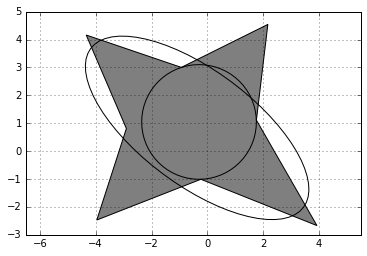

In [3]:
# Change this name to match the dicom file located in the same directory
# as this notebook.
dicom_filename = "star.dcm"  

dcm = dicom.read_file(dicom_filename, force=True)
applicator_string = dcm.BeamSequence[0].ApplicatorSequence[0].ApplicatorID
energy_string = dcm.BeamSequence[0].ControlPointSequence[0].NominalBeamEnergy
ssd_string = dcm.BeamSequence[0].ControlPointSequence[0].SourceToSurfaceDistance

print("Applicator = {} (identifier name)".format(applicator_string))
print("Energy = {} (nominal)".format(energy_string))
print("SSD = {} (dicom units)\n".format(ssd_string))

block_data = np.array(dcm.BeamSequence[0].BlockSequence[0].BlockData)
x = np.array(block_data[0::2]).astype(float)/10
y = np.array(block_data[1::2]).astype(float)/10

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm".format(width))
print("Length = {0:0.2f} cm".format(length))

display_parameterisation(x, y, width, length, poi)

### From Monaco 5.10 tel file

The following code is what is used at RCCC to automatically pull and parameterise shapes from the server based off of patient ID. For use in other centres it will need adjustment.

In [4]:
# Find a tel file on server
# patientID = 'not_telling'
# string_search_pattern = r'\\MONACODA\FocalData\RCCC\1~Clinical\*{}\plan\*\*tel.1'.format(patientID)
# filepath_list = glob(string_search_pattern)
# print(filepath_list)

In [5]:
telfilepath = "example_monaco510_telfile"
electronmodel_regex = "RiverinaAgility - \d+MeV"  # \d+ stands for any positive integer

with open(telfilepath, "r") as file:
    telfilecontents = np.array(file.read().splitlines())

electronmodel_index = []
for i, item in enumerate(telfilecontents):
    if re.search(electronmodel_regex, item):
        electronmodel_index += [i]

print("Located applicator and energy strings for plans within telfile:")
applicator_tel_string = [
    telfilecontents[i+12]  # applicator string is located 12 lines below electron model name
    for i in electronmodel_index]
print(applicator_tel_string)

energy_tel_string = [
    telfilecontents[i-1]  # energy string is located 1 line before electron model name
    for i in electronmodel_index]
print(energy_tel_string)

Located applicator and energy strings for plans within telfile:
['14X14']
['15 MeV']


Applicator = 14X14
Energy = 15 MeV

Width = 8.76 cm
Length = 14.00 cm


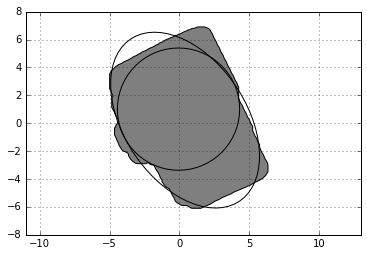

In [6]:
for i, index in enumerate(electronmodel_index):
    print("Applicator = {}".format(applicator_tel_string[i]))
    print("Energy = {}\n".format(energy_tel_string[i]))
    
    insert_inital_range = telfilecontents[
        index + 51::]  # coords start 51 lines after electron model name
    insert_stop = np.where(
        insert_inital_range=='0')[0][0]  # coords stop right before a line containing 0
    
    insert_coords_string = insert_inital_range[:insert_stop]
    insert_coords = np.fromstring(','.join(insert_coords_string), sep=',')
    x = insert_coords[0::2]/10
    y = insert_coords[1::2]/10
    
    width, length, poi = parameterise_single_insert(x, y)
    print("Width = {0:0.2f} cm".format(width))
    print("Length = {0:0.2f} cm".format(length))
    display_parameterisation(x, y, width, length, poi)

## Recording all the data

## Displaying a given applicator / energy / ssd combination

## Creating reports for all data with at least 8 data point

## Copyright information
Copyright &#169; 2015  Simon Biggs

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.